In [2]:
from google.colab import drive
drive.mount('/content/drive')
% cd drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [3]:
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision.models as models
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
epochs = 10
batch_size = 32
lr = 0.005
num_workers = 3
image_height, image_width = 64, 64

In [5]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, image_folder, column_label):
        assert Path(csv_path).exists()
        assert Path(csv_path).is_file()
        
        assert Path(image_folder).exists() 
        assert Path(image_folder).is_dir()
        
        
        self.df = pd.read_csv(csv_path)
        self.image_folder = Path(image_folder)
        self.transform = T.Compose([
            T.ToTensor(),
            T.Resize((image_height, image_width)),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.3)
        ])
        
        assert column_label in self.df.columns
        self.column_label = column_label
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index]['Id'] + '.jpg'
        image_path = self.image_folder.joinpath(filename)
        image = self.transform(Image.open(image_path))
        
        label = self.df.loc[index][self.column_label]
        
        return image, label

In [6]:
def accuracy(output, target):
  output, target = output.detach().cpu().numpy(), target.detach().cpu().numpy()
  tf = output > 0.4
  binary_output = tf.astype(int)
  return accuracy_score(target, binary_output)

def con_mat(output, target):
  output, target = output.detach().cpu().numpy(), target.detach().cpu().numpy()
  tf = output > 0.4
  binary_output = tf.astype(int)
  return confusion_matrix(target, binary_output)

In [7]:
# columns - Pawpularity, Blur, Info, Occlusion, Human, Collage, Group, Accessory, Action, Near, Face, Near, Eyes, Focus
response = 'Blur'
pawpularity_dataset = CustomDataset('petfinder_data/train.csv', 'petfinder_data/train/', response)
train_size = int(len(pawpularity_dataset) * 0.8)
test_size = len(pawpularity_dataset) - train_size
paw_train_data, paw_test_data = torch.utils.data.random_split(pawpularity_dataset, [train_size, test_size])

In [8]:
train_data = torch.utils.data.DataLoader(paw_train_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)
test_data = torch.utils.data.DataLoader(paw_test_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)

In [9]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# import efficient net
efficient_net = models.efficientnet_b3(pretrained=True).to(device)

# don't update on model parameters
for param in efficient_net.parameters():
    param.requires_grad = False

# replace model classifier to fit our data
efficient_net.classifier[1] = nn.Sequential(nn.Sequential(
                    nn.Linear(1536, 256),
                    nn.ReLU(), 
                    nn.Dropout(0.2),
                    nn.Linear(256, 1),
                    nn.Sigmoid()).to(device))

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(efficient_net.classifier.parameters(), lr=lr)

In [11]:
avg_train_loss, avg_test_loss = [], []
avg_train_acc, avg_test_acc = [], []
confusion_matrices = []

for epoch in range(epochs):
    
    train_loss, test_loss = 0, 0 
    train_acc, test_acc = 0, 0

    i = 0
    for inputs, labels in train_data:
        inputs = inputs.to(device)
        labels = labels.reshape(len(labels), 1).to(torch.float32).to(device)
        
        # zero out gradients
        optimizer.zero_grad()
        
        outputs = efficient_net(inputs)
      
        loss = criterion(outputs, labels)
        train_loss += loss
        train_acc += accuracy(outputs, labels)
        train_cm = con_mat(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print('Epoch: {:<3d} \t Batch: {:>3d}/{:<3d}  \t Avg Train Accuracy: {:>2.2f} \t Avg Train Loss: {:>3.2f}'.format(epoch, 
                                                                                                                              i, 
                                                                                                                              len(train_data), 
                                                                                                                              train_acc / (i+1),
                                                                                                                              train_loss/(i+1)))
        i += 1

    v = 0
    for test_inputs, test_labels in test_data:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.reshape(len(test_labels), 1).to(torch.float32).to(device)
        
        with torch.no_grad():
          test_out = efficient_net(test_inputs)
          tloss = criterion(test_out, test_labels)
          test_loss += tloss
          test_acc += accuracy(test_out, test_labels)
        
        if epoch == (epochs - 1):
          confusion_matrices.append(con_mat(test_out, test_labels))

              
        if v % 10 == 0:
          print('Epoch: {:<3d} \t Batch: {:>3d}/{:<3d} \t Avg Test Accuracy: {:>2.2f} \t Avg Test Loss: {:>3.2f}'.format(epoch, 
                                                                                                                             v, 
                                                                                                                             len(test_data), 
                                                                                                                             test_acc / (v+1),
                                                                                                                             test_loss/(v+1)))
        v += 1

    avg_train_loss.append(train_loss / len(train_data))
    avg_test_loss.append(test_loss / len(test_data))
    avg_train_acc.append(train_acc / len(train_data))
    avg_test_acc.append(test_acc / len(test_data))

Epoch: 0   	 Batch:   0/248  	 Avg Train Accuracy: 0.03 	 Avg Train Loss: 0.66
Epoch: 0   	 Batch:   1/248  	 Avg Train Accuracy: 0.45 	 Avg Train Loss: 0.46
Epoch: 0   	 Batch:   2/248  	 Avg Train Accuracy: 0.58 	 Avg Train Loss: 0.43
Epoch: 0   	 Batch:   3/248  	 Avg Train Accuracy: 0.64 	 Avg Train Loss: 0.42
Epoch: 0   	 Batch:   4/248  	 Avg Train Accuracy: 0.68 	 Avg Train Loss: 0.38
Epoch: 0   	 Batch:   5/248  	 Avg Train Accuracy: 0.71 	 Avg Train Loss: 0.38
Epoch: 0   	 Batch:   6/248  	 Avg Train Accuracy: 0.74 	 Avg Train Loss: 0.37
Epoch: 0   	 Batch:   7/248  	 Avg Train Accuracy: 0.75 	 Avg Train Loss: 0.43
Epoch: 0   	 Batch:   8/248  	 Avg Train Accuracy: 0.76 	 Avg Train Loss: 0.46
Epoch: 0   	 Batch:   9/248  	 Avg Train Accuracy: 0.78 	 Avg Train Loss: 0.46
Epoch: 0   	 Batch:  10/248  	 Avg Train Accuracy: 0.79 	 Avg Train Loss: 0.47
Epoch: 0   	 Batch:  11/248  	 Avg Train Accuracy: 0.80 	 Avg Train Loss: 0.45
Epoch: 0   	 Batch:  12/248  	 Avg Train Accuracy: 0

In [12]:
save_path = '/content/drive/MyDrive/Colab Notebooks/'
save_name = 'blur_detection'

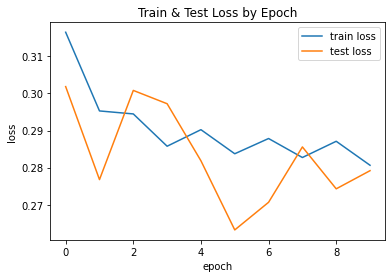

In [13]:
ep = np.arange(epochs)

plt.plot(ep, torch.stack(avg_train_loss).cpu().detach().numpy(), label='train loss')
plt.plot(ep, torch.stack(avg_test_loss).cpu().detach().numpy(), label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train & Test Loss by Epoch')
plt.legend()
plt.savefig(save_path + save_name)

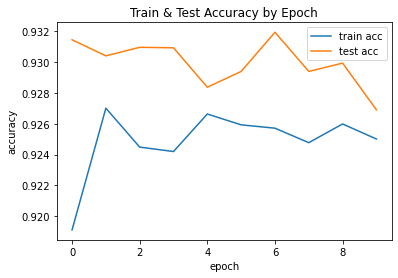

In [14]:
ep = np.arange(epochs)

plt.plot(ep, avg_train_acc, label='train acc')
plt.plot(ep, avg_test_acc, label='test acc')
#plt.plot(ep, torch.stack(avg_train_acc).cpu().detach().numpy(), label='train acc')
#plt.plot(ep, torch.stack(avg_test_acc).cpu().detach().numpy(), label='test acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train & Test Accuracy by Epoch')
plt.legend()
plt.savefig(save_path + save_name + '_acc')

In [15]:
pickle.dump(efficient_net, open(save_path + save_name + '.sav', 'wb'))

In [35]:
len(confusion_matrices[0])

2

In [37]:
tn, fp, fn, tp = 0, 0, 0, 0

for i in range(len(confusion_matrices)):
  if len(confusion_matrices[i]) == 2:
    tn += confusion_matrices[i][0][0]
    fp += confusion_matrices[i][0][1]
    fn += confusion_matrices[i][1][0]
    tp += confusion_matrices[i][1][1]
  else:
    pass

print('tn: {} \t fp: {} \t fn: {} \t tp: {}'.format(tn, fp, fn, tp))

tn: 1740 	 fp: 11 	 fn: 134 	 tp: 2
